**Menginput Library yang diperlukan**




In [6]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

**Membaca Data**

In [7]:
df = pd.read_csv('application_train.csv')

In [8]:
df.sample(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
16093,118771,0,Cash loans,F,N,Y,3,225000.0,1271929.5,48577.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Mencari Pola dari data**

Jumlah nasabah yang mengajukan pinjaman

In [9]:
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

noc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,Customers_pct
0,0,17872,0.92
1,1,1523,0.08


Status Pernikahan

In [10]:
df.NAME_FAMILY_STATUS.value_counts()

Married                 12528
Single / not married     2783
Civil marriage           1881
Separated                1200
Widow                    1003
Name: NAME_FAMILY_STATUS, dtype: int64

In [11]:
Marital_status = []
married = ['Married', 'Civil marriage']

for i in df.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df['Marital_status'] = Marital_status
df.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [12]:
ms_acc = df[df['TARGET'] == 0].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_acc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_acc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
ms_acc

,Marital_status,Customers,Customers_pct
0,Married,13321,0.92
1,Unmarried,4551,0.08


In [13]:
ms_nacc = df[df['TARGET'] == 1].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_nacc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_nacc['Customers_pct'] = round(ms_nacc.Customers / ms_nacc.Customers.sum(), 2)
ms_nacc

,Marital_status,Customers,Customers_pct
0,Married,1088,0.71
1,Unmarried,435,0.29


In [14]:
ms= df[df['Marital_status'] == 'Unmarried'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms['Customers_pct'] = round(ms.Customers / ms.Customers.sum(), 2)
ms

,TARGET,Marital_status,Customers,Customers_pct
0,0,Unmarried,4551,0.91
1,1,Unmarried,435,0.09


In [15]:
ms1= df[df['Marital_status'] == 'Married'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms1.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms1['Customers_pct'] = round(ms1.Customers / ms1.Customers.sum(), 2)
ms1

,TARGET,Marital_status,Customers,Customers_pct
0,0,Married,13321,0.92
1,1,Married,1088,0.08


Kontrak Type

In [16]:
ct = df.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by = 'NAME_CONTRACT_TYPE')
ct.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_ct = list(ct['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_of_ct:
    data = ct[ct['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ct['Percent'] = percentage
ct

,TARGET,NAME_CONTRACT_TYPE,Customers,Percent
0,0,Cash loans,16098,0.92
2,1,Cash loans,1438,0.08
1,0,Revolving loans,1774,0.95
3,1,Revolving loans,85,0.05


In [17]:
ot = df.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_of_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['percentage'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,percentage
0,0,Accountants,575,0.94
18,1,Accountants,35,0.06
1,0,Cleaning staff,255,0.89
19,1,Cleaning staff,30,0.11
2,0,Cooking staff,337,0.90
20,1,Cooking staff,36,0.10
3,0,Core staff,1640,0.94
21,1,Core staff,110,0.06
4,0,Drivers,1024,0.88
22,1,Drivers,135,0.12


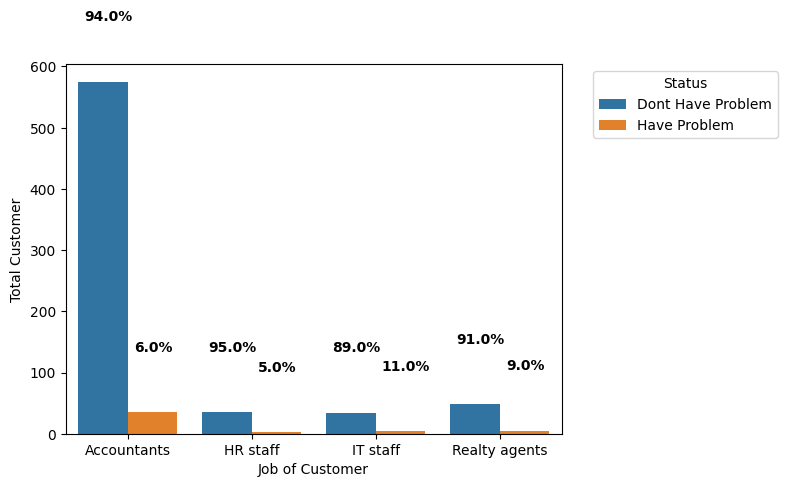

In [18]:
ot_2 = ot[ot['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents', 'Accountants'])]
ot_2 = ot_2.reset_index()
ot_2.drop(columns = 'index', inplace=True)

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

ot_2['TARGET'] = ot_2['TARGET'].map(mapping_target)


ax = sns.barplot(x = 'OCCUPATION_TYPE', y= 'Customers', hue= 'TARGET', data = ot_2)
plt.xlabel('Job of Customer')
plt.ylabel('Total Customer')
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(ot_2['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v + 100, s= str(ot_2['percentage'][i]* 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 100, s= str(ot_2['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)

In [19]:
df['Age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)
df.drop(columns= 'DAYS_BIRTH', inplace=True)

In [20]:
age_cat = []
for i in df['Age']:
    if i < 36:
        age_cat.append('Young Adult')
    elif i < 51:
        age_cat.append('Adult')
    else:
        age_cat.append('Older')

df['Age_category'] = age_cat


In [21]:
g_age = df.groupby(['TARGET', 'Age_category'])['CODE_GENDER'].count().reset_index().sort_values('Age_category').reset_index()
g_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
g_age.drop(columns = 'index', inplace=True)

name_of_ot = list(g_age['Age_category'].unique())
percentage = []

for i in name_of_ot:
    data = g_age[g_age['Age_category'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

g_age['percentage'] = percentage

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

g_age['TARGET'] = g_age['TARGET'].map(mapping_target)
g_age

,TARGET,Age_category,Customers,percentage
0,Dont Have Problem,Adult,6857,0.92
1,Have Problem,Adult,584,0.08
2,Dont Have Problem,Older,5744,0.95
3,Have Problem,Older,306,0.05
4,Dont Have Problem,Young Adult,5271,0.89
5,Have Problem,Young Adult,633,0.11


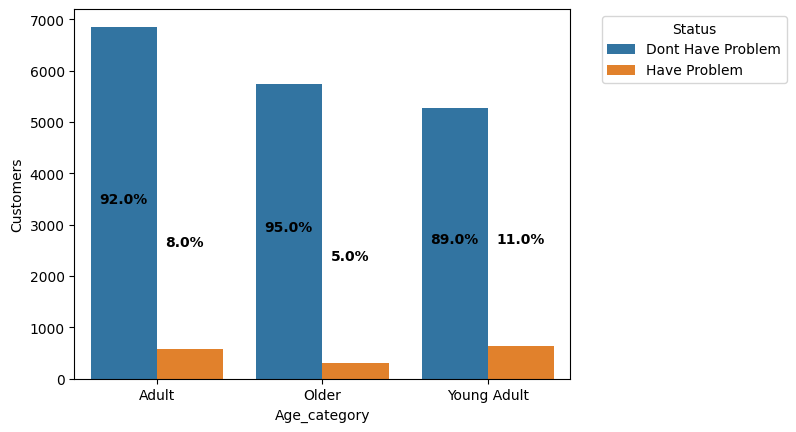

In [22]:
ax = sns.barplot(x = 'Age_category', y= 'Customers', hue= g_age.TARGET, data = g_age)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(g_age['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v/2, s= str(g_age['percentage'][i]* 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 2000, s= str(g_age['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)

In [23]:
df.drop(columns = 'Age_category', inplace=True)

In [24]:
itc = df.groupby(['TARGET', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']).reset_index()
itc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
itc.drop(columns = 'index', inplace=True)

income_type   = list(itc['NAME_INCOME_TYPE'].unique())
percentage  = []

for i in income_type:
    data = itc[itc.NAME_INCOME_TYPE == i]
    contract_type = list(data['NAME_CONTRACT_TYPE'].unique())
    for x in contract_type:
        data2 = data[data.NAME_CONTRACT_TYPE == x]
        total = data2['Customers'].sum()
        for y,z in enumerate(data2['Customers']):
            pct = round(z / total, 2)
            percentage.append(pct)

itc['percentage'] = percentage
itc

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,0,Commercial associate,Cash loans,3669,0.92
1,1,Commercial associate,Cash loans,318,0.08
2,0,Commercial associate,Revolving loans,470,0.97
3,1,Commercial associate,Revolving loans,16,0.03
4,0,Pensioner,Cash loans,3063,0.95
5,1,Pensioner,Cash loans,176,0.05
6,0,Pensioner,Revolving loans,209,0.98
7,1,Pensioner,Revolving loans,5,0.02
8,0,State servant,Cash loans,1139,0.95
9,1,State servant,Cash loans,66,0.05


Data Cleanning

In [28]:
df.duplicated().sum()

0

In [29]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
46,COMMONAREA_AVG,13562,69.925238
74,COMMONAREA_MEDI,13562,69.925238
60,COMMONAREA_MODE,13562,69.925238
82,NONLIVINGAPARTMENTS_MEDI,13454,69.368394
68,NONLIVINGAPARTMENTS_MODE,13454,69.368394
54,NONLIVINGAPARTMENTS_AVG,13454,69.368394
84,FONDKAPREMONT_MODE,13280,68.471255
80,LIVINGAPARTMENTS_MEDI,13254,68.337200
52,LIVINGAPARTMENTS_AVG,13254,68.337200
66,LIVINGAPARTMENTS_MODE,13254,68.337200


In [30]:
data = list(count_nv[count_nv['Percentage'] > 40]['index'])
df = df.drop(columns = data)
df = df.drop(columns = 'SK_ID_CURR')

In [31]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
still_null = count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [32]:
a = list(still_null['index'])
df[a].dtypes

for i in a:
    data = df[i]
    types = str(data.dtype)
    if types == 'object':
        df[i].fillna(df[i].mode()[0], inplace=True)
    else:
        df[i].fillna(df[i].median(), inplace=True)

In [33]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


In [34]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

In [35]:
FLAG_DOCUMENT = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df.drop(columns = FLAG_DOCUMENT, axis=1, inplace=True)

In [36]:
x = df.drop(columns = 'TARGET')

In [37]:
num = x.select_dtypes(exclude='object')

In [38]:
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-637,-3648.0,-2120,1,...,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-225,-4260.0,-2531,1,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-3039,-9833.0,-2437,1,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-3038,-4311.0,-3458,1,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


In [39]:
negative_column = num.columns[(num < 0).any()].tolist()
num[negative_column] = num[negative_column] * -1
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,1,...,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,1,...,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,1,...,0.0,0.0,815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,1,...,2.0,0.0,617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,1,...,0.0,0.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


In [40]:
df_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
df_num = df_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

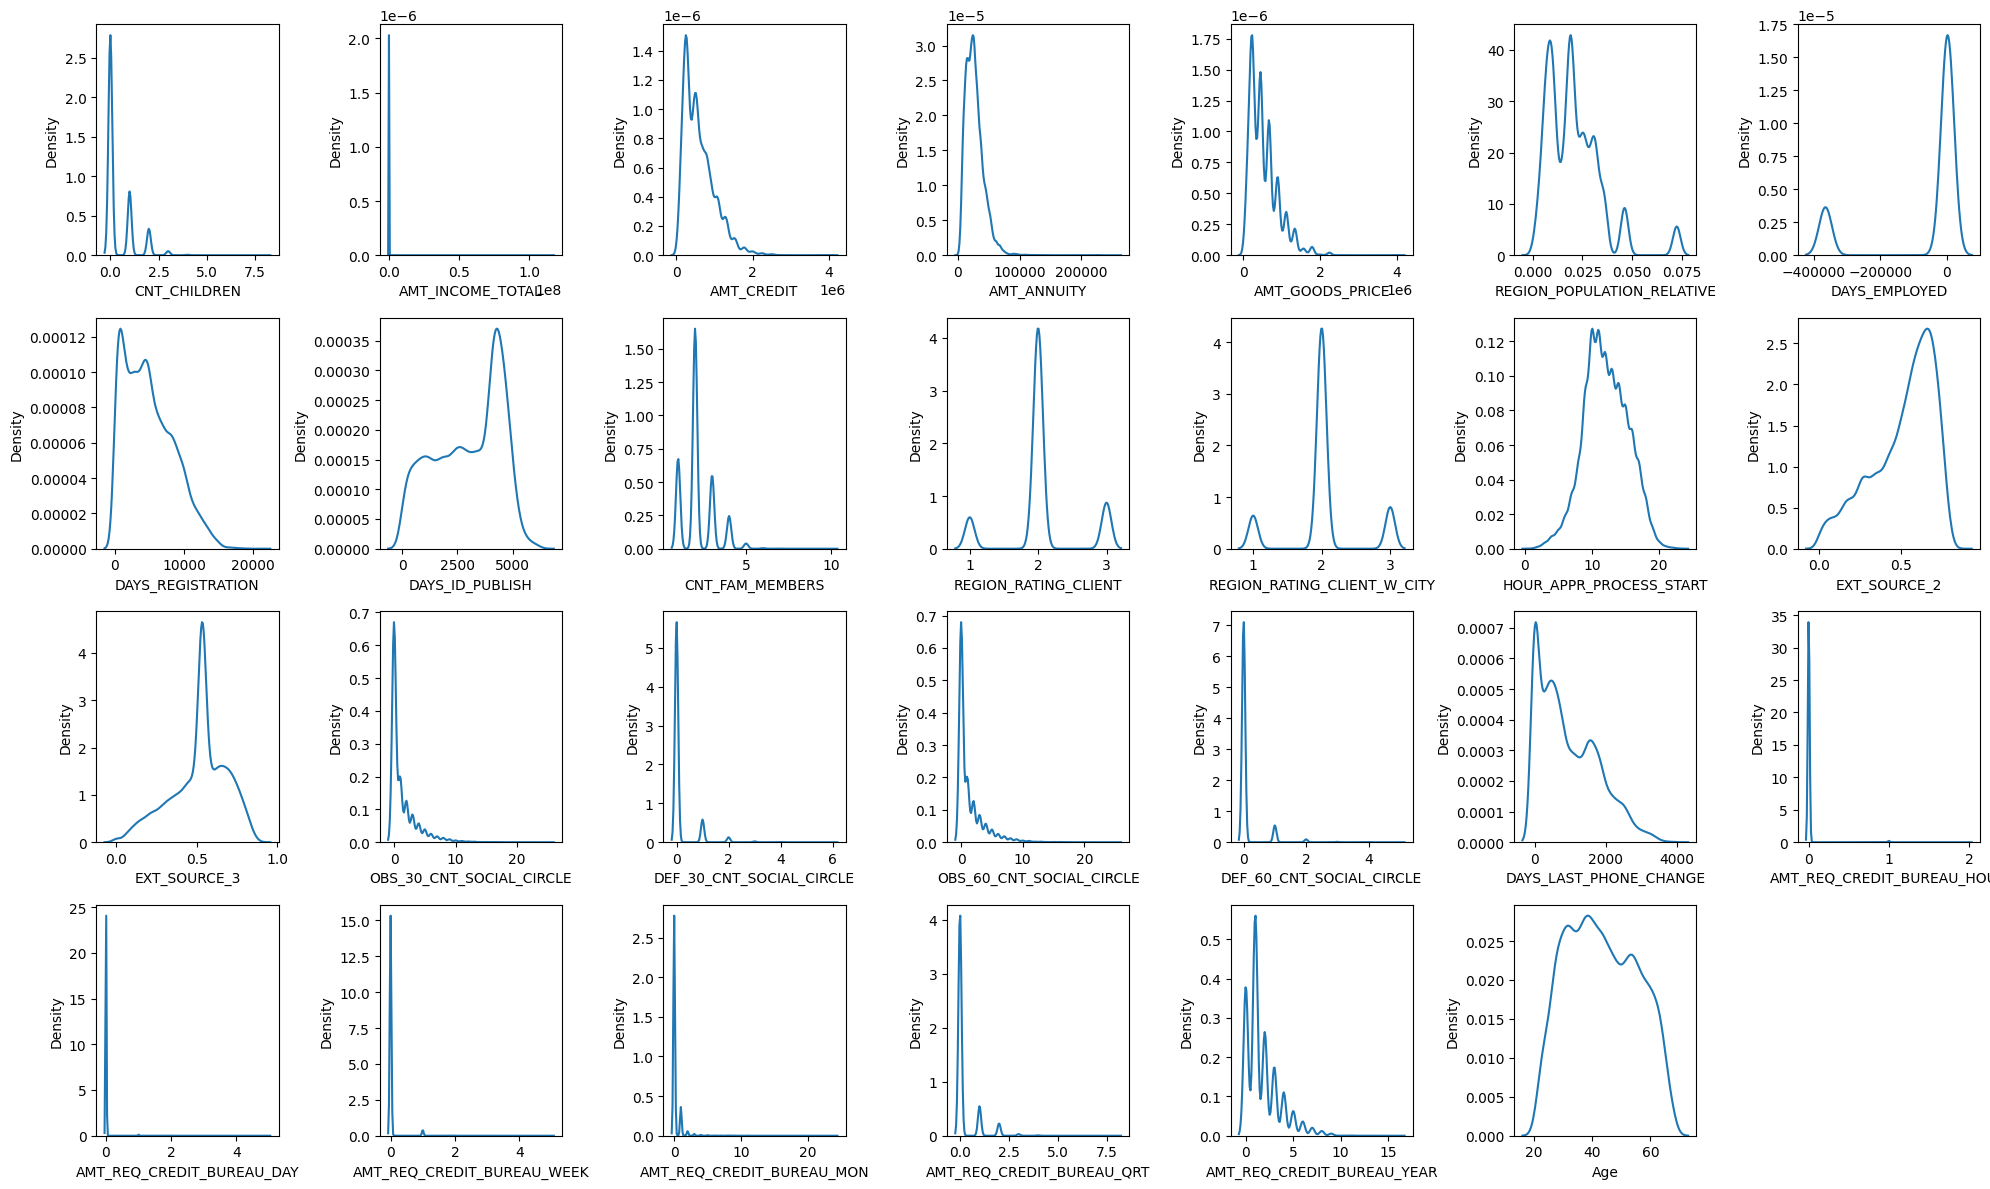

In [41]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(4,7,i)
    sns.kdeplot(data=num[num_a], x=num[column])
    plt.tight_layout()

In [42]:
print(f'Row before delete outlier at CNT_children :  {len(df)}')

filtered_entries = np.array([True] * len(df))

zscore = abs(stats.zscore(df['CNT_CHILDREN'])) # hitung absolute z-scorenya
filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya

df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Row after delete outlier at CNT_children : {len(df)}')

Row before delete outlier at CNT_children :  19395
Row after delete outlier at CNT_children : 19109


In [43]:
x = df.drop(columns = 'TARGET', axis=1)
num = x[num_a]

In [44]:
num_mean = num.mean()
num_std = num.std()

num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.590853,0.033624,-0.480462,-0.165112,-0.508752,-0.142021,-0.456746,0.378926,0.572683,-1.341957,...,0.263043,5.176268,-0.209222,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-0.438173,-1.542650
1,-0.590853,0.112992,1.719383,0.592384,1.591346,-1.249165,-0.460643,1.076513,1.781969,-0.139788,...,-0.175990,-0.276054,0.161470,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-1.005722,0.131009
2,-0.590853,-0.125110,-1.154122,-1.401467,-1.091438,-0.778230,-0.453832,0.205521,0.300940,-1.341957,...,-0.615024,-0.276054,0.177218,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-1.005722,0.716790
3,-0.590853,-0.045743,-0.713405,0.178303,-0.654424,-0.924277,-0.473734,-1.373542,0.363091,-0.139788,...,0.263043,-0.276054,0.417077,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-0.438173,0.716790
4,-0.590853,-0.061616,-0.216545,-0.360375,-0.071737,0.573488,-0.473727,0.191070,-0.311968,-1.341957,...,-0.615024,-0.276054,-0.175303,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-1.005722,0.884156


In [45]:
num_1 = x[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.590853,0.033624,-0.480462,-0.165112,-0.508752,-0.142021,-0.456746,0.378926,0.572683,-1.341957,...,0,1,1,0,0,0,0,0,0,0
1,-0.590853,0.112992,1.719383,0.592384,1.591346,-1.249165,-0.460643,1.076513,1.781969,-0.139788,...,0,1,1,0,0,0,0,0,0,0
2,-0.590853,-0.125110,-1.154122,-1.401467,-1.091438,-0.778230,-0.453832,0.205521,0.300940,-1.341957,...,1,1,1,0,0,0,0,0,0,0
3,-0.590853,-0.045743,-0.713405,0.178303,-0.654424,-0.924277,-0.473734,-1.373542,0.363091,-0.139788,...,0,1,0,0,0,0,0,0,0,0
4,-0.590853,-0.061616,-0.216545,-0.360375,-0.071737,0.573488,-0.473727,0.191070,-0.311968,-1.341957,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19390,-0.590853,0.007168,-0.901066,-1.023959,-0.970045,0.135418,-0.463826,1.145932,0.028537,-0.139788,...,0,1,0,0,0,0,0,0,1,1
19391,-0.590853,-0.045743,0.450474,-0.077709,0.365277,0.725267,-0.478763,0.203537,-0.926860,-0.139788,...,0,1,0,0,0,0,0,0,0,0
19392,0.979032,-0.098655,-0.361646,-0.541381,-0.229548,1.090712,-0.456244,1.061496,1.526756,1.062380,...,0,1,0,0,0,0,0,0,0,0
19393,0.979032,-0.151566,-1.154122,-1.401467,-1.091438,0.725267,-0.468868,0.967426,-0.881900,1.062380,...,1,1,0,0,0,0,0,0,1,1


In [46]:
obj = x.select_dtypes(include='object')
df_obj = pd.DataFrame(obj.nunique(), columns = ['Total_unique']).reset_index()
df_obj = df_obj.rename(columns = {'index' : 'Name_of_column'})

obj_1 = []
obj_2 = []
for i,y in enumerate(df_obj.Name_of_column):
    if df_obj['Total_unique'][i] > 2:
        obj_1.append(y)
    else:
        obj_2.append(y)
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,Marital_status
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Unmarried
1,Cash loans,F,N,N,Family,State servant,Higher education,House / apartment,Core staff,MONDAY,School,Married
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Government,Unmarried
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Married
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Core staff,THURSDAY,Religion,Unmarried
...,...,...,...,...,...,...,...,...,...,...,...,...
19390,Cash loans,F,Y,Y,Unaccompanied,State servant,Secondary / secondary special,House / apartment,Medicine staff,FRIDAY,Medicine,Married
19391,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,FRIDAY,Business Entity Type 3,Married
19392,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Cooking staff,TUESDAY,Business Entity Type 3,Married
19393,Revolving loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,FRIDAY,Self-employed,Married


In [47]:
for cat in obj_1:
    onehots = pd.get_dummies(obj[cat], prefix=cat)
    obj = obj.join(onehots)

obj = obj.drop(columns = obj_1)

In [48]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
for cat in obj_2:
    obj[cat]= label_encoder.fit_transform(obj[cat])

obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,Marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19390,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19391,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19392,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19393,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df_train = pd.concat([num, obj], axis=1)

In [50]:
df = pd.concat([df_train, df['TARGET']],axis=1)

In [51]:
x = df.drop(columns = 'TARGET')
y = df['TARGET']

In [52]:
sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x, y.ravel())

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

In [54]:
rus = RandomUnderSampler(random_state=42)
x_under, y_under = rus.fit_resample(x, y.ravel())

In [55]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size=0.3, random_state=42)

In [56]:
def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5297
           1       1.00      0.90      0.95      5274

    accuracy                           0.95     10571
   macro avg       0.95      0.95      0.95     10571
weighted avg       0.95      0.95      0.95     10571



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


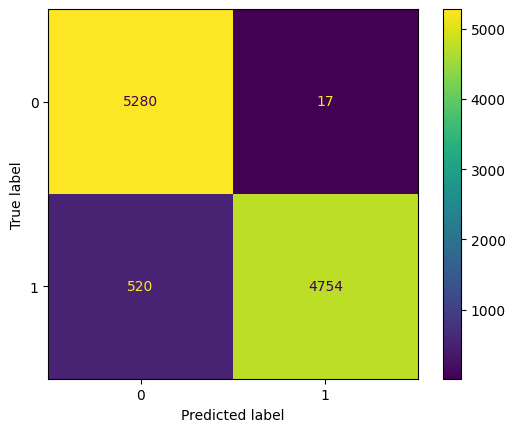

In [57]:
lr1 = LogisticRegression()
lr1.fit(x_train, y_train.ravel())
predictions = lr1.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12320
           1       1.00      0.90      0.95     12343

    accuracy                           0.95     24663
   macro avg       0.95      0.95      0.95     24663
weighted avg       0.95      0.95      0.95     24663



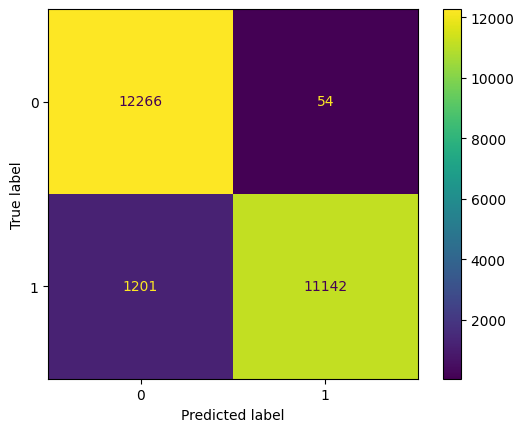

In [58]:
predictions = lr1.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       458
           1       0.67      0.67      0.67       438

    accuracy                           0.68       896
   macro avg       0.68      0.68      0.68       896
weighted avg       0.68      0.68      0.68       896



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


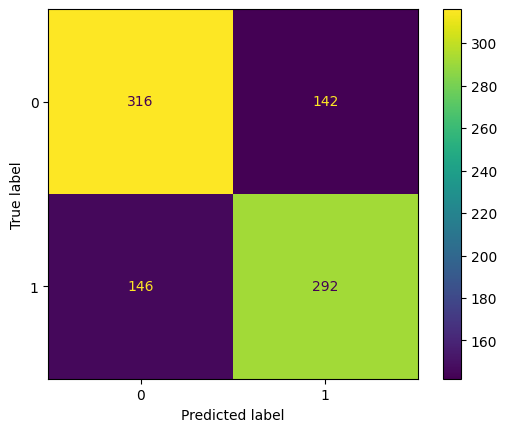

In [59]:
lr2 = LogisticRegression()
lr2.fit(x_train2, y_train2)
predictions2 = lr2.predict(x_test2)

# print classification report
print(classification_report(y_test2, predictions2))
confusionmatrix(predictions2, y_test2)

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1034
           1       0.71      0.70      0.71      1054

    accuracy                           0.71      2088
   macro avg       0.71      0.71      0.71      2088
weighted avg       0.71      0.71      0.71      2088



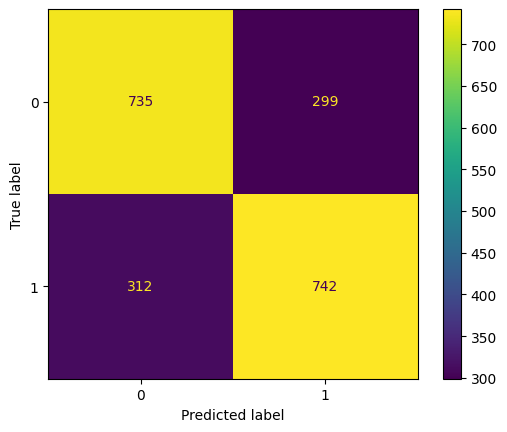

In [60]:
predictions = lr2.predict(x_train2)

# print classification report
print(classification_report(y_train2, predictions))
confusionmatrix(predictions, y_train2)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5297
           1       0.99      0.92      0.96      5274

    accuracy                           0.96     10571
   macro avg       0.96      0.96      0.96     10571
weighted avg       0.96      0.96      0.96     10571



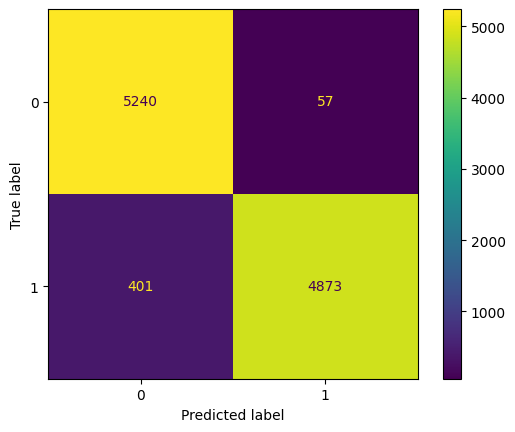

In [61]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train.ravel())

predictions = xgb_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     12320
           1       1.00      0.97      0.99     12343

    accuracy                           0.99     24663
   macro avg       0.99      0.99      0.99     24663
weighted avg       0.99      0.99      0.99     24663



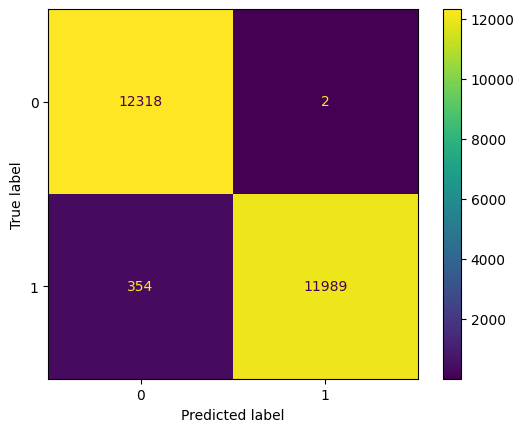

In [62]:
predictions = xgb_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5297
           1       1.00      0.93      0.96      5274

    accuracy                           0.96     10571
   macro avg       0.97      0.96      0.96     10571
weighted avg       0.97      0.96      0.96     10571



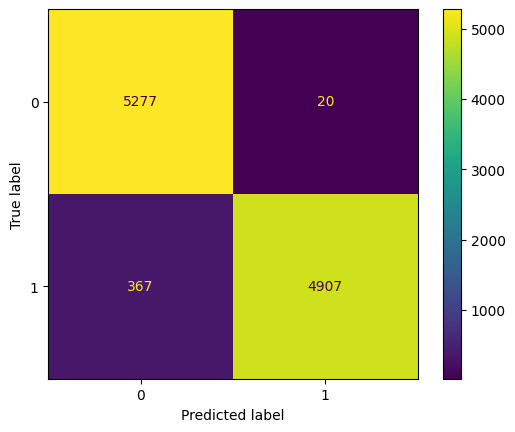

In [63]:
rf_model = RandomForestClassifier().fit(x_train, y_train)
predictions = rf_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12320
           1       1.00      1.00      1.00     12343

    accuracy                           1.00     24663
   macro avg       1.00      1.00      1.00     24663
weighted avg       1.00      1.00      1.00     24663



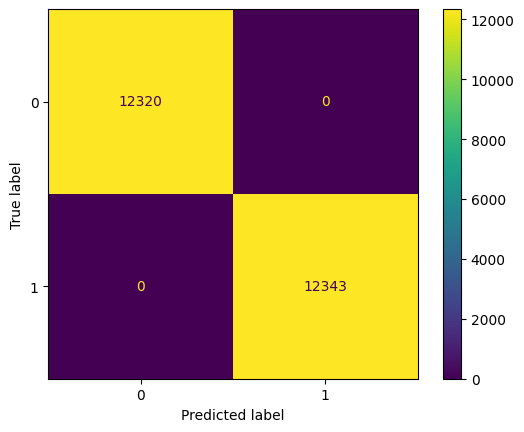

In [64]:
predictions = rf_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

In [65]:
df_test = pd.read_csv('application_test.csv')

In [66]:
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].replace(['XNA'], df_test['CODE_GENDER'].mode()[0])
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(['XNA'], df_test['ORGANIZATION_TYPE'].mode()[0])

Marital_status = []
married = ['Married', 'Civil marriage']

for i in df_test.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df_test['Marital_status'] = Marital_status
df_test.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

df_test['Age'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)
df_test.drop(columns= 'DAYS_BIRTH', inplace=True)

In [67]:
count_nv = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
still_null = count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

In [68]:
a = list(still_null['index'])

for i in a:
    data = df_test[i]
    types = str(data.dtype)
    if types == 'object':
        df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    else:
        df_test[i].fillna(df_test[i].median(), inplace=True)

In [69]:
num = df_test[num_a]

In [70]:
num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.590853,-0.045743,-0.078141,-0.450258,-0.241688,-0.138466,-0.468713,-0.052320,1.437498,-0.139788,...,-0.615024,-0.276054,-0.943337,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,-1.005722,0.716790
1,-0.590853,-0.088072,-0.936426,-0.670006,-0.970045,1.090712,-0.483848,-1.170953,0.901286,-0.139788,...,-0.615024,-0.276054,1.164518,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,0.696925,0.465741
2,-0.590853,0.033624,0.156164,2.939568,0.243884,-0.120255,-0.483770,0.796288,-0.341721,-0.139788,...,-0.615024,-0.276054,0.127550,-0.078917,-0.063822,-0.158918,-0.266831,1.338657,1.264474,0.884156
3,2.548918,0.165903,2.417599,1.509809,2.793136,0.408722,-0.465438,0.845873,-0.807848,2.264548,...,-0.615024,-0.276054,-1.022079,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,0.696925,-0.454771
4,0.979032,0.007168,0.062495,0.342261,0.231745,-0.778230,-0.467737,0.279190,-0.843552,1.062380,...,-0.615024,-0.276054,0.169950,-0.078917,-0.063822,-0.158918,-0.266831,-0.396313,0.129376,-0.705820


In [71]:
num_1 = df_test[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.590853,-0.045743,-0.078141,-0.450258,-0.241688,-0.138466,-0.468713,-0.052320,1.437498,-0.139788,...,0,1,0,1,0,0,0,0,0,0
1,-0.590853,-0.088072,-0.936426,-0.670006,-0.970045,1.090712,-0.483848,-1.170953,0.901286,-0.139788,...,0,1,0,0,0,0,0,0,0,0
2,-0.590853,0.033624,0.156164,2.939568,0.243884,-0.120255,-0.483770,0.796288,-0.341721,-0.139788,...,0,1,0,0,0,0,0,0,0,0
3,2.548918,0.165903,2.417599,1.509809,2.793136,0.408722,-0.465438,0.845873,-0.807848,2.264548,...,0,1,1,0,0,0,0,0,0,0
4,0.979032,0.007168,0.062495,0.342261,0.231745,-0.778230,-0.467737,0.279190,-0.843552,1.062380,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15419,-0.590853,-0.019287,-0.230263,0.149168,-0.217409,-0.138466,2.130913,0.995477,1.305924,-1.341957,...,0,1,0,0,0,0,0,0,0,0
15420,0.979032,0.023042,1.229555,1.997037,0.972242,-0.840407,-0.465615,1.065463,-0.440897,1.062380,...,0,1,0,0,0,0,0,0,0,0
15421,-0.590853,-0.098655,-1.265738,-1.165292,-1.212831,-0.154137,-0.503771,-1.006898,-1.592662,-0.139788,...,0,1,0,0,0,0,0,0,1,1
15422,0.979032,-0.035161,-1.154122,-0.913620,-1.091438,0.856296,-0.468989,-0.465715,-0.822394,1.062380,...,0,1,1,0,0,0,0,0,0,0


In [72]:
obj = df_test.select_dtypes(include='object')

for cat in obj_1:
    onehots = pd.get_dummies(obj[cat], prefix=cat)
    obj = obj.join(onehots)

obj = obj.drop(columns = obj_1)

In [73]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
for cat in obj_2:
    obj[cat]= label_encoder.fit_transform(obj[cat])

obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,Marital_status,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,0,0,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15419,0,0,0,0,reg oper account,block of flats,"Stone, brick",No,1,0,...,0,0,0,0,0,0,0,0,0,0
15420,0,1,0,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
15421,0,0,0,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
15422,0,0,0,1,reg oper spec account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
  df_test = pd.concat([num, obj], axis=1)


In [75]:
train = set(df.columns)

In [76]:
train.remove('TARGET')

In [77]:
not_in_test = train - set(df_test.columns)
not_in_test = list(not_in_test)

In [78]:
df_test[not_in_test] = 0

In [79]:
column_train = list(df.columns)
column_train.remove('TARGET')
df_test = df_test[column_train]

In [80]:
predictions = rf_model.predict(df_test)

In [81]:
df_test['TARGET'] = predictions

In [82]:
df_test['TARGET'].value_counts()

0    15313
1      111
Name: TARGET, dtype: int64